In [1]:
import pandas as pd
import numpy as np
from phik.report import plot_correlation_matrix
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
    classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('dark_background')

In [19]:
df_raw = pd.read_csv('/kaggle/input/leopard-challenge-classification/train.csv')
test = pd.read_csv(r'/kaggle/input/leopard-challenge-classification/test.csv')
df_raw.shape, test.shape

((13863, 26), (5942, 25))

In [20]:
test_cv = test.drop(['oral', 'ID'], axis = 1).copy()
test_cv['tartar'] = test_cv['tartar'].apply(lambda x: 1 if x == 'Y' else 0)
merged_data = df_raw.drop(['oral', 'ID'], axis=1).copy()
merged_data['tartar'] = merged_data['tartar'].apply(lambda x: 1 if x == 'Y' else 0)

In [18]:
                Feature  Importance
20     log_triglyceride    6.905796
0                   age    6.705330
12           hemoglobin    6.479102
22              log_alt    5.483010
11                  HDL    5.429639
9   fasting blood sugar    5.168988
16                  Gtp    5.098710
15                  AST    4.744928
23              log_LDL    4.744309
14     serum creatinine    4.721506
19                  BMI    4.531897
8            relaxation    4.458011
7              systolic    4.372855
25              gtp_bin    4.325584
10          Cholesterol    4.013675
18               tartar    3.879546
2             waist(cm)    3.878390
3        eyesight(left)    3.839101
4       eyesight(right)    3.242842
1            height(cm)    3.096483
21       weight(kg)_log    2.247812
17        dental caries    1.865837
13        Urine protein    0.318056
26         waist_normal    0.212703
24    BMI_dental_caries    0.188457
5         hearing(left)    0.033205
6        hearing(right)    0.014230

SyntaxError: invalid syntax (622278634.py, line 1)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


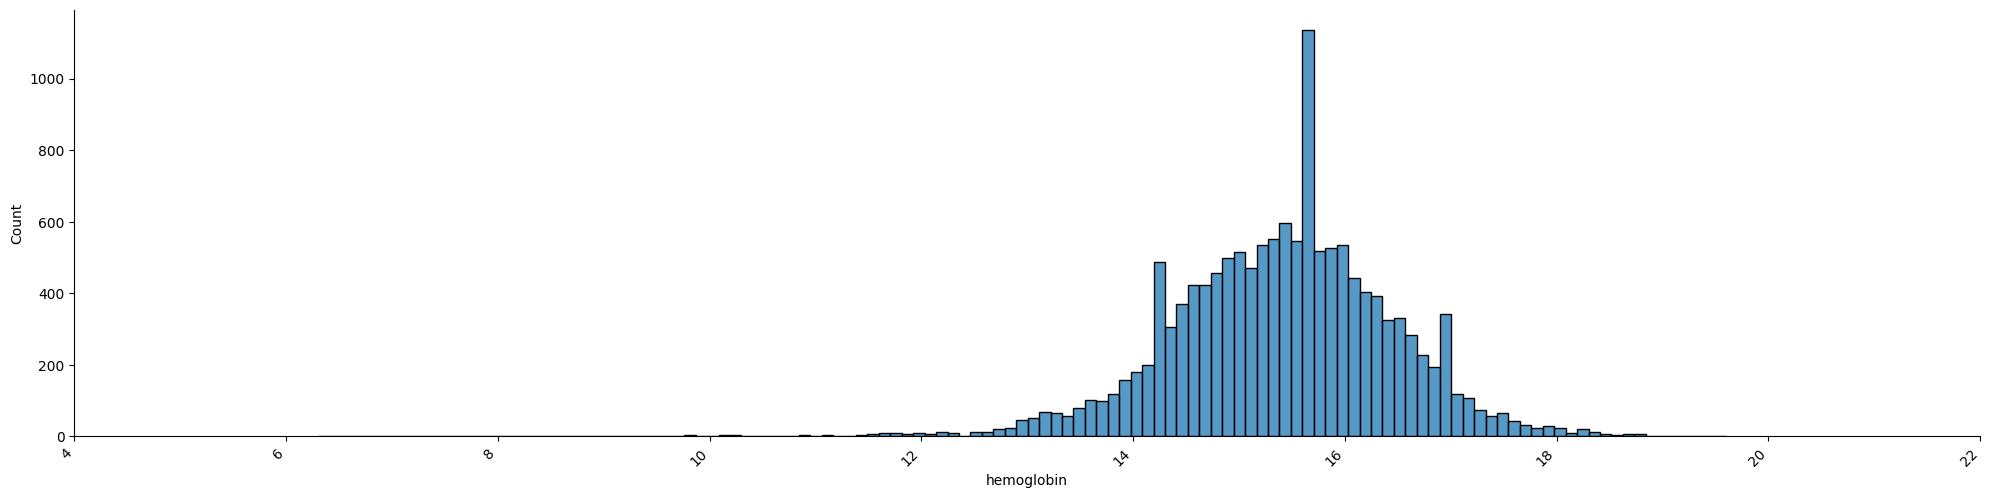

In [199]:
g = sns.displot(data= merged_data,
            x = 'hemoglobin',
#             y = 'deviation_normal',
#             hue='target_class',
            aspect = 4, 
            legend=True)

g.set_xticklabels(rotation=45, horizontalalignment='right', step = 1);

<Axes: >

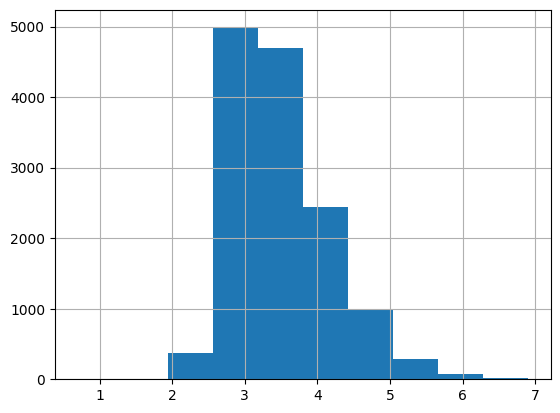

In [126]:
# merged_data['relaxation_bin'] = pd.qcut(merged_data['relaxation'], q=5, labels=False)
# merged_data.groupby('triglyceride')['smoking'].agg(['count', 'sum'])#.index
merged_data['Gtp'].apply(np.log).hist()
# merged_data['age'].hist()

In [311]:
# Создание бинарного признака на основе BMI
# merged_data['BMI'] = merged_data['weight(kg)'] / ((merged_data['height(cm)'] / 100) ** 2)
merged_data['log_triglyceride'] = merged_data['triglyceride'].apply(np.log)
# merged_data['weight(kg)_log'] = merged_data['weight(kg)'].apply(np.log)
# merged_data['log_alt'] = merged_data['ALT'].apply(np.log)
# merged_data['log_LDL'] = merged_data['LDL'].apply(np.log)
# merged_data['BMI_status'] = (merged_data['BMI'] < 18.5) | (merged_data['BMI'] >= 24.9)
# merged_data['BMI_status'] = merged_data['BMI_status'].astype(int)
# merged_data['BMI_dental_caries'] = merged_data.apply(lambda row: 0 if (row['BMI_status'] == 1 and row['dental caries'] == 1) else 1, axis=1)
# merged_data['log_gtp'] = merged_data['Gtp'].apply(np.log) 
# merged_data['gtp_bin'] = pd.qcut(merged_data['log_gtp'], q=8, labels=False)
# merged_data['waist_normal'] = (merged_data['waist(cm)'] < 90.1).astype(int)
# merged_data['triglyceride_normal'] = (merged_data['triglyceride'] < 115).astype(int)
# merged_data['Gtp_normal'] = (merged_data['Gtp'] > 32).astype(int)
# merged_data['serum_creatinine_log'] = merged_data['serum creatinine'].apply(np.log)

merged_data = merged_data.drop([
                                'triglyceride',
#                                 'weight(kg)',
#                                 'Gtp',
#                                 'ALT',
#                                 'LDL',
#                                 'BMI_status',
#                                 'log_gtp'
                                            ], axis=1) # , 'Gtp' , 'HDL', 'age' 

In [21]:
target_variable = 'smoking'

cat_features = [ 'dental caries', 'tartar' ] # 'hearing(left)', 'hearing(right)', 'Urine protein',, 'BMI_status' , 'age_group'

merged_data[cat_features] = merged_data[cat_features].astype(str)
non_cat_features = [col for col in merged_data.columns if col not in cat_features and col != target_variable]

In [22]:
from sklearn.model_selection import train_test_split

X = merged_data.drop(['smoking'], axis=1) 
y = merged_data['smoking']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape

((11090, 23), (2773, 23))

In [23]:
from sklearn.preprocessing import MinMaxScaler

# Масштабирование признаков
scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
X_train[non_cat_features] = scaler.fit_transform(X_train[non_cat_features])
X_test[non_cat_features] = scaler.transform(X_test[non_cat_features])

X_train.shape, X_test.shape

((11090, 23), (2773, 23))

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((8872, 23), (2218, 23), (8872,), (2218,))

In [30]:
from sklearn.model_selection import StratifiedKFold
import optuna
from sklearn.metrics import roc_auc_score, average_precision_score


def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 2500),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']), # 
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 5),
        'depth': trial.suggest_int('depth', 10, 13), # 10, 13
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.06), # 0.001, 0.06
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 6, 20),
        'border_count': trial.suggest_int('border_count', 40, 200),
        'od_type': 'Iter', 
        'od_wait': 50, 
        'eval_metric': 'AUC',
        'logging_level': 'Silent',
        'random_seed': 42,
        'auto_class_weights': 'Balanced'
    }
    
    roc_aucs = []
    avg_precs = []
    
    # Создание 5 фолдов
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        y_val_fold = y_train.iloc[val_idx]

        model = CatBoostClassifier(**params)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], use_best_model=True, early_stopping_rounds=params['od_wait'], cat_features=cat_features) # cat_features
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        avg_prec = average_precision_score(y_test, y_pred_proba)
        
        roc_aucs.append(roc_auc)
        avg_precs.append(avg_prec)
    
    # Возвращаем средние значения метрик по всем фолдам
    return np.mean(roc_aucs), np.mean(avg_precs)


In [31]:
from optuna.pruners import MedianPruner

In [32]:
%%time 
study = optuna.create_study(pruner=MedianPruner(), directions=['maximize', 'maximize'] ) #pruner=MedianPruner(),
study.optimize(objective,
               n_jobs=-1,
               n_trials=20, # 25 показывает результат лучше
               show_progress_bar=True
              )

best_trial = study.best_trials[0]

roc_auc_best = best_trial.values[0]
avg_prec_best = best_trial.values[1]
print(f"Лучшее значение ROC AUC: {roc_auc_best:.4f}")
print(f"Лучшее значение Average Precision: {avg_prec_best:.4f}")

[I 2023-10-19 10:37:44,763] A new study created in memory with name: no-name-55f2ce90-61a1-48b4-abd7-97e980569d7f


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-19 10:40:34,438] Trial 1 finished with values: [0.7190975405073914, 0.40864487356805146] and parameters: {'iterations': 1651, 'boosting_type': 'Plain', 'bagging_temperature': 3.964955703625706, 'depth': 10, 'learning_rate': 0.05629876338920226, 'l2_leaf_reg': 12.208615004140311, 'border_count': 176}. 


KeyboardInterrupt: 

In [33]:
import optuna.visualization as vis


def target_function(trial):
    return trial.values[0]  # 0 соответствует первой метрике (ROC AUC)

vis.plot_slice(study, params=['depth', 'l2_leaf_reg', 'iterations', 'learning_rate' ], target=target_function)

/opt/conda/lib/python3.10/site-packages/optuna/visualization/_utils.py:67: UserWarning:

`target` is specified, but `target_name` is the default value, 'Objective Value'.



In [34]:
vis.plot_slice(study, params=['bagging_temperature', 'border_count', 'boosting_type'], target=target_function)

In [14]:
import optuna.visualization as vis
def target_function(trial):
    return trial.values[0] 
# n_trials=50  'od_wait': 50    n_splits=5
# Наивысший F1: 0.45147
vis.plot_slice(study, params=['depth', 'l2_leaf_reg', 'iterations', 'learning_rate' ], target=target_function)

/opt/conda/lib/python3.10/site-packages/optuna/visualization/_utils.py:67: UserWarning: `target` is specified, but `target_name` is the default value, 'Objective Value'.
  warnings.warn(


In [15]:
vis.plot_slice(study, params=['bagging_temperature', 'border_count', 'boosting_type'], target=target_function)

/opt/conda/lib/python3.10/site-packages/optuna/visualization/_utils.py:67: UserWarning:

`target` is specified, but `target_name` is the default value, 'Objective Value'.



In [12]:
from sklearn.metrics import f1_score

# Возьмите параметры из лучшего trial на основе первой метрики (ROC AUC в данном случае)
best_params = study.best_trials[0].params

model = CatBoostClassifier(**best_params, auto_class_weights='Balanced', logging_level='Silent') #  task_type='GPU' auto_class_weights='Balanced' , 

model.fit(X_train, y_train, verbose=100, cat_features=cat_features) # cat_features

y_pred_proba = model.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.01, 1, 300)
f1_scores = [f1_score(y_test, y_pred_proba > thresh) for thresh in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)] 

# print(f"Оптимальный порог: {optimal_threshold:.5f}")
print(f"Наивысший F1: {max(f1_scores):.5f}")

Наивысший F1: 0.45147


In [ ]:
Наивысший F1: 0.44580/0.44977/0.44529

In [229]:
# Получение значимости признаков
feature_importances = model.get_feature_importance()

# Создание датафрейма для лучшей визуализации
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Сортировка признаков по их значимости
features_df = features_df.sort_values(by='Importance', ascending=False)

print(features_df)

                Feature  Importance
18                  Gtp    7.826973
21     log_triglyceride    7.169888
13           hemoglobin    7.143747
0                   age    6.109762
9   fasting blood sugar    5.737625
2             waist(cm)    5.697937
11                  HDL    5.612655
17                  ALT    5.466217
12                  LDL    5.161894
16                  AST    4.878865
15     serum creatinine    4.859747
7              systolic    4.809646
8            relaxation    4.677498
10          Cholesterol    4.286746
3        eyesight(left)    4.183451
20               tartar    3.768261
1            height(cm)    3.601052
4       eyesight(right)    3.558849
22       weight(kg)_log    3.237434
19        dental caries    1.875130
14        Urine protein    0.249519
5         hearing(left)    0.048979
6        hearing(right)    0.038129


In [483]:
print(features_df)

                Feature  Importance
20     log_triglyceride    7.577701
0                   age    7.205848
25              gtp_bin    5.905521
12           hemoglobin    5.731822
16                  Gtp    5.386926
14     serum creatinine    4.976144
23              log_LDL    4.891343
22              log_alt    4.829822
19                  BMI    4.342010
11                  HDL    4.231676
18               tartar    4.146208
2             waist(cm)    3.976079
15                  AST    3.882255
3        eyesight(left)    3.750060
10          Cholesterol    3.648761
7              systolic    3.548185
27       relaxation_bin    3.532683
9   fasting blood sugar    3.450195
1            height(cm)    3.356066
4       eyesight(right)    2.994842
8            relaxation    2.935861
17        dental caries    2.264984
21       weight(kg)_log    2.146626
26         waist_normal    0.645393
13        Urine protein    0.357815
24    BMI_dental_caries    0.237641
5         hearing(left)    0

In [90]:
model.save_model("catboost_model_best_params_06.cbm")

In [91]:
import json

with open("catboost_best_parameters_06.json", "w") as f:
    json.dump(best_params, f)


In [403]:

data_test_cv = test_cv[["HDL", "LDL"]].copy()

# Создаём полиномиальные признаки
poly_test_cv = PolynomialFeatures(degree=2, include_bias=False)
poly_features_test_cv = poly.fit_transform(data_test_cv)

# Добавляем полиномиальные признаки к копии исходных данных
poly_data_test_cv = pd.concat([data_test_cv, pd.DataFrame(poly_features_test_cv)], axis=1)
poly_data_test_cv.shape

(5942, 11)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


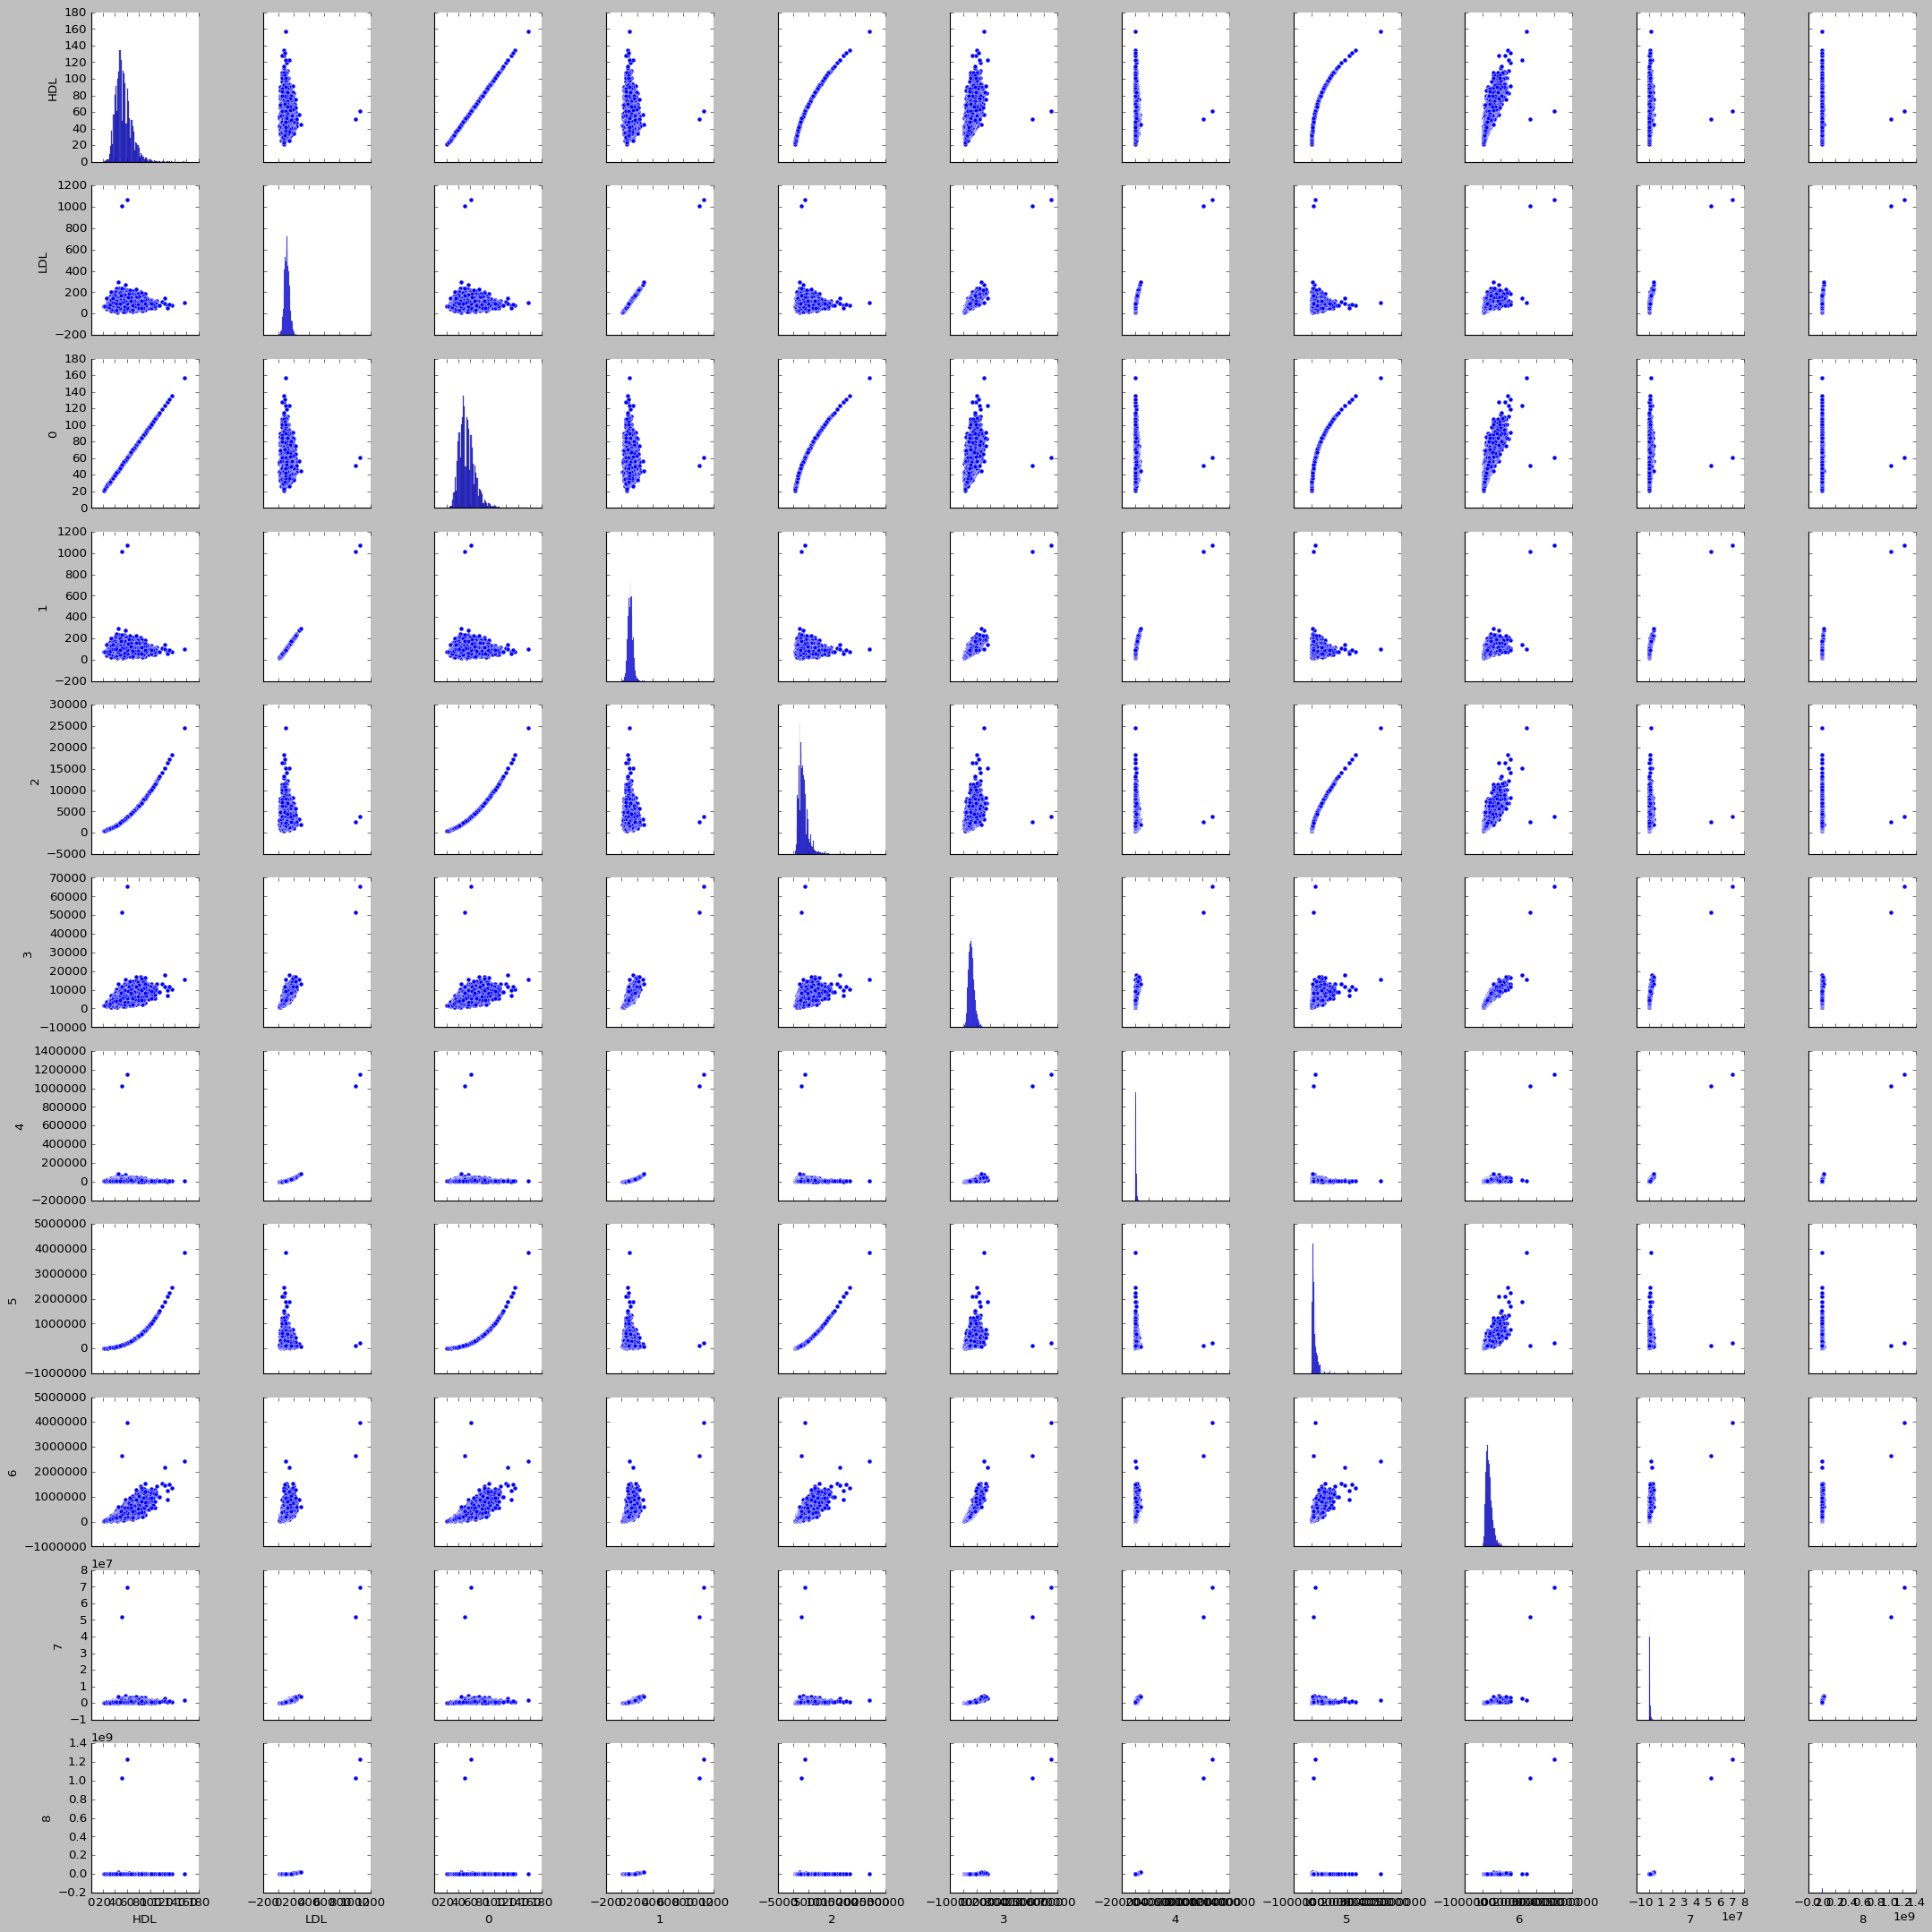

In [405]:
# Выводим парные графики между всеми признаками
sns.pairplot(poly_data_test_cv)
plt.show()